# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Reading the Dataset and Preparing them for Analysis

In [1]:
# loading all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

from utilities import *
from preprocess import *
%matplotlib inline

### Portfolio

In [30]:
portfolio = get_data('data/portfolio.json')
portfolio.shape

(10, 6)

In [31]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [32]:
df_po = process_portfolio(portfolio)
df_po.head()

,reward,difficulty,duration,offer_type,offer_id,ch_email,ch_mobile,ch_social,ch_web,tot_channels
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,3
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,4
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,3
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,3
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,2


### Profile

In [33]:
profile = get_data('data/profile.json')
profile.shape

(17000, 5)

In [34]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [35]:
profile['id'].nunique()

17000

In [36]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [37]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Some unusual age values are observed and testing whether they have any relations withthe `na` values observed.

In [38]:
profile[profile['age'] == 118].isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Profiles which have unrealistic age values missing gender and income information as well. Those profiles needd to be flagged.

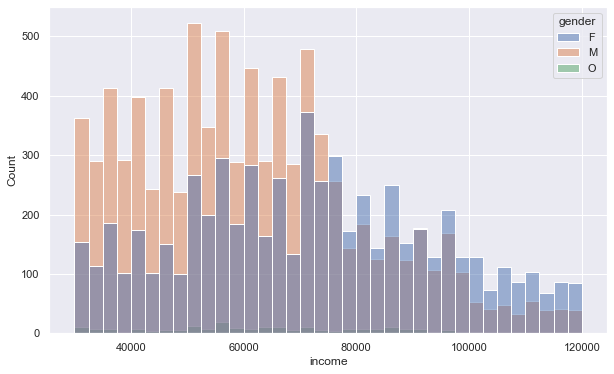

In [39]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=profile, x="income", hue="gender")
plt.show()

Its evident that Starbucks male customers are towards lower income compared to the female customers.

In [40]:
# pre process the Profile data
df_pf = process_profile(profile)
df_pf.head()

,gender,age,customer_id,became_member_on,income,gn_F,gn_M,gn_O,member_for,pf_age_valid
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,4.51,False
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,4.09,True
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,3.10,False
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,4.27,True
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,4.03,False


### Transcript

In [41]:
transcript = get_data('data/transcript.json')
transcript.shape

(306534, 4)

In [42]:
transcript.sample(5)

,person,event,value,time
282113,9f2e7a00443644188720ca9edc74370c,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},624
287805,394775ef5c614facb20af9e4fc9a9f23,transaction,{'amount': 19.31},636
204317,7979224ed8ca46a7be6112db5f498986,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},504
154884,9a674564f21d4478bed54a86b25fceb0,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},408
144931,fb65d7d6d86b4ed796c52f1a980dfd9b,transaction,{'amount': 21.15},384


In [43]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

There is no Null value in the Transcript dataset provided.

In [44]:
transcript['person'].nunique()

17000

Transcript data contains 17000 users' 306534 transaction records.

In [45]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Number of transactions for each customer varies and one customer's transaction looks like the following

In [46]:
transcript[transcript.person == '1e99a5d7cda04316ab07978b5fa641e4']

,person,event,value,time
32774,1e99a5d7cda04316ab07978b5fa641e4,transaction,{'amount': 13.4},60
54660,1e99a5d7cda04316ab07978b5fa641e4,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168
66252,1e99a5d7cda04316ab07978b5fa641e4,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168
112293,1e99a5d7cda04316ab07978b5fa641e4,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},336
127480,1e99a5d7cda04316ab07978b5fa641e4,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},342
203044,1e99a5d7cda04316ab07978b5fa641e4,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},504
214736,1e99a5d7cda04316ab07978b5fa641e4,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},504
258387,1e99a5d7cda04316ab07978b5fa641e4,transaction,{'amount': 21.71},576
258388,1e99a5d7cda04316ab07978b5fa641e4,offer completed,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,576
300796,1e99a5d7cda04316ab07978b5fa641e4,transaction,{'amount': 27.89},690


Same record is converted as follows for analysis purposes after preprocessing the dataset.

In [47]:
# process the Transcript data
df_ts = process_transcript(transcript)
df_ts[df_ts.customer_id == '1e99a5d7cda04316ab07978b5fa641e4']

,customer_id,event,time,offer_id,amount,reward
32774,1e99a5d7cda04316ab07978b5fa641e4,transaction,60,NaN,13.40,NaN
54660,1e99a5d7cda04316ab07978b5fa641e4,offer received,168,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
66252,1e99a5d7cda04316ab07978b5fa641e4,offer viewed,168,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
112293,1e99a5d7cda04316ab07978b5fa641e4,offer received,336,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
127480,1e99a5d7cda04316ab07978b5fa641e4,offer viewed,342,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
203044,1e99a5d7cda04316ab07978b5fa641e4,offer received,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
214736,1e99a5d7cda04316ab07978b5fa641e4,offer viewed,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
258387,1e99a5d7cda04316ab07978b5fa641e4,transaction,576,NaN,21.71,NaN
258388,1e99a5d7cda04316ab07978b5fa641e4,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0
300796,1e99a5d7cda04316ab07978b5fa641e4,transaction,690,NaN,27.89,NaN


In [48]:
any_duplicates(df_ts)

Number of duplicate record: 0


Duplicate records are removed during pre processing steps.

### Merge all datasets

Merging all 03 dataset

In [49]:
trans_pf = pd.merge(df_ts, df_pf, on='customer_id', how="left")
df_tsall = pd.merge(trans_pf, df_po, on='offer_id', how='left')
df_tsall.shape

(306137, 24)

In [50]:
# replacing all offer_ids with new name
df_transall = df_tsall.replace({'offer_id' : offer_names})

In [51]:
df_transall.shape

(306137, 24)

In [52]:
df_transall.head()

,customer_id,event,time,offer_id,amount,reward_x,gender,age,became_member_on,income,...,pf_age_valid,reward_y,difficulty,duration,offer_type,ch_email,ch_mobile,ch_social,ch_web,tot_channels
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,b3,NaN,NaN,F,75.0,2017-05-09,100000.0,...,True,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,3.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,d1,NaN,NaN,None,NaN,2017-08-04,NaN,...,False,5.0,20.0,10.0,discount,1.0,0.0,0.0,1.0,2.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,d4,NaN,NaN,M,68.0,2018-04-26,70000.0,...,True,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,3.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,d3,NaN,NaN,None,NaN,2017-09-25,NaN,...,False,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,4.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,b2,NaN,NaN,None,NaN,2017-10-02,NaN,...,False,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,4.0


## Offer Level Information

Ten types of offers given to the customers and all of them can be categorized as BOGO, Discount and Informational. Offers are analysed at Offer Level and ID level to get more understanding about them.

### Offer Type: How many Offers Sent

Viewing Offer received, viewed and completed details at Offer_Type level

In [53]:
get_Offers_nEvents(df_transall, offer_split = 'offer_type')

,offer_type,offer completed,offer received,offer viewed,off_rec_viewed,off_rec_completed
0,bogo,15501.0,30499.0,25449.0,0.83,0.51
1,discount,17681.0,30543.0,21445.0,0.70,0.58
2,informational,NaN,15235.0,10831.0,0.71,NaN


### Offer Type: How many Customers Received it

In [84]:
def count_Unique_Offers(df, offer_split):
  ''' count how many customers received each offers '''
  
  df_t = df.copy()
  df_sm = df_t.groupby(['event', offer_split]).agg(unique_cust = ('customer_id', 'nunique')).reset_index()
  df_sm_pv = df_sm.pivot(index=offer_split, columns='event', values='unique_cust').reset_index()
  df_sm_pv = df_sm_pv.rename_axis(None, axis = 1)

  # create additional ratio information
  df_sm_pv['off_rec_viewed'] = round(df_sm_pv['offer viewed']/df_sm_pv['offer received'], 2)
  df_sm_pv['off_rec_completed'] = round(df_sm_pv['offer completed']/df_sm_pv['offer received'], 2)
  tot_cust = df_t['customer_id'].nunique()
  df_sm_pv['perc_recv_offer'] = round(df_sm_pv['offer received']*100/tot_cust, 2)
  
  return df_sm_pv

Viewing howmany customers received the offer, this will reveal whether the offers are sent randomly across customers

In [54]:
count_Unique_Offers(df_transall, offer_split = 'offer_type')

,offer_type,offer completed,offer received,offer viewed,off_rec_viewed,off_rec_completed,perc_recv_offer
0,bogo,9263.0,14992.0,14008.0,0.93,0.62,88.19
1,discount,10289.0,14945.0,12676.0,0.85,0.69,87.91
2,informational,NaN,10547.0,8251.0,0.78,NaN,62.04


### Offer ID: How many Offers Sent

Viewing Offer received, viewed and completed details at Offer_ID level

In [55]:
get_Offers_nEvents(df_transall, offer_split = 'offer_id')

,offer_id,offer completed,offer received,offer viewed,off_rec_viewed,off_rec_completed
0,b1,3635.0,7658.0,6716.0,0.88,0.47
1,b2,3301.0,7593.0,7298.0,0.96,0.43
2,b3,4303.0,7677.0,4171.0,0.54,0.56
3,b4,4262.0,7571.0,7264.0,0.96,0.56
4,d1,3340.0,7668.0,2663.0,0.35,0.44
5,d2,5112.0,7646.0,7337.0,0.96,0.67
6,d3,5265.0,7597.0,7327.0,0.96,0.69
7,d4,3964.0,7632.0,4118.0,0.54,0.52
8,i1,NaN,7617.0,4144.0,0.54,NaN
9,i2,NaN,7618.0,6687.0,0.88,NaN


### Offer ID: How many Customers Received it

In [56]:
count_Unique_Offers(df_transall, offer_split = 'offer_id')

,offer_id,offer completed,offer received,offer viewed,off_rec_viewed,off_rec_completed,perc_recv_offer
0,b1,3177.0,6374.0,5696.0,0.89,0.50,37.49
1,b2,2885.0,6330.0,6132.0,0.97,0.46,37.24
2,b3,3784.0,6355.0,3658.0,0.58,0.60,37.38
3,b4,3741.0,6262.0,6060.0,0.97,0.60,36.84
4,d1,2978.0,6374.0,2400.0,0.38,0.47,37.49
5,d2,4421.0,6325.0,6122.0,0.97,0.70,37.21
6,d3,4530.0,6332.0,6150.0,0.97,0.72,37.25
7,d4,3480.0,6285.0,3608.0,0.57,0.55,36.97
8,i1,NaN,6331.0,3635.0,0.57,NaN,37.24
9,i2,NaN,6320.0,5674.0,0.90,NaN,37.18


## Analysing Missing Values

Personal information such as gender, age and income are missing together in some customer profiles. 
This need to be analysed to undersatand they have any distinct characteristics from the rest.

Imputing values for missing information is critical as many important information are missing together.

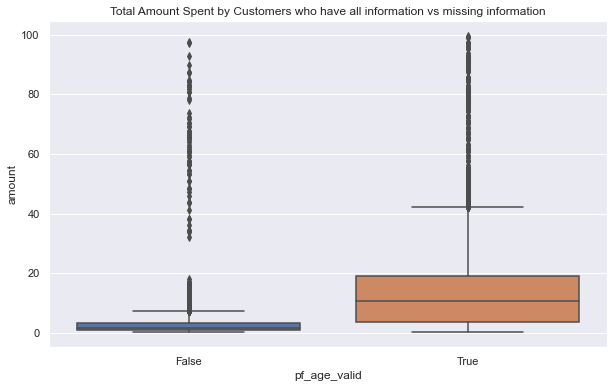

In [57]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="pf_age_valid", y="amount",
                    data=df_transall[df_transall.amount < 100])
plt.title("Total Amount Spent by Customers who have all information vs missing information")
plt.show()

Above box plot shows purchasing power of customer that have missing information is less than rest of them.

## Customer Level Information

Aggregated individual level information is created in this part to understand the customer behavior towards Starbucks offers.

### Total Transactions and Rewards

In [58]:
# get transaction and reward information for all customers 
df_ind_amount = get_TransactionRewards(df_transall, df_pf)
df_ind_amount.head()

,customer_id,tot_amount,n_trans,tot_rewards,n_rewards,val_trans,val_rewards,gender,age,income,member_for,pf_age_valid
0,0009655768c64bdeb2e877511632db8f,127.60,8,9.0,3,15.95,3.00,M,33.0,72000.0,4.32,True
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3,0.0,0,1.36,NaN,None,NaN,NaN,3.31,False
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5,13.0,3,15.89,4.33,O,40.0,57000.0,3.60,True
3,0020c2b971eb4e9188eac86d93036a77,196.86,8,14.0,3,24.61,4.67,F,59.0,90000.0,5.45,True
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,13.0,3,12.84,4.33,F,24.0,60000.0,4.76,True


#### Transactions

In [59]:
# using customer data which has valid age, income and gender information
df_ind_amt_v = df_ind_amount[df_ind_amount.pf_age_valid == True]
df_ind_amt_v.shape

(14825, 12)

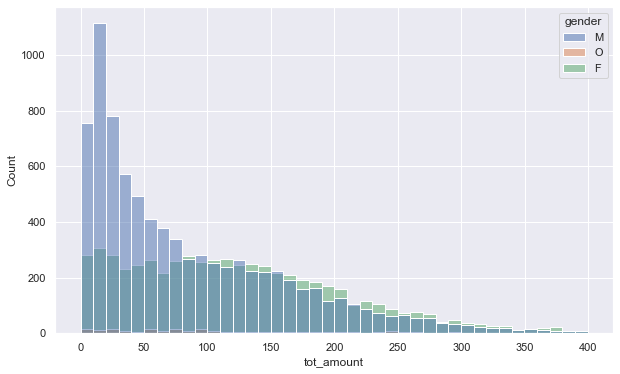

In [60]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ind_amt_v[df_ind_amt_v.tot_amount < 400], x="tot_amount", hue="gender")
plt.show()

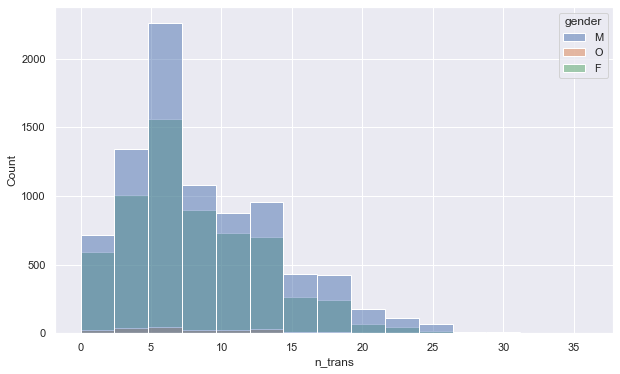

In [61]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ind_amt_v, x="n_trans", bins=15, hue="gender")
plt.show()

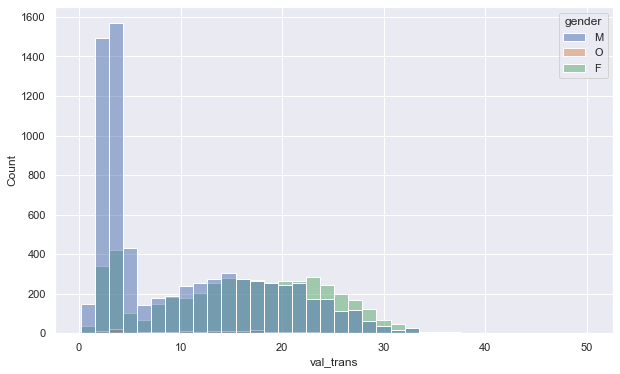

In [62]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ind_amt_v[df_ind_amt_v.tot_amount < 200], x="val_trans", hue="gender")
plt.show()

In [63]:
df_ind_amt_v[df_ind_amt_v.tot_amount > 500].shape[0], df_ind_amt_v[df_ind_amt_v.val_trans > 100].shape[0]

(272, 105)

Over 250 people spend more than 500 dollars and about 100 average transaction values are above 100 dollars.

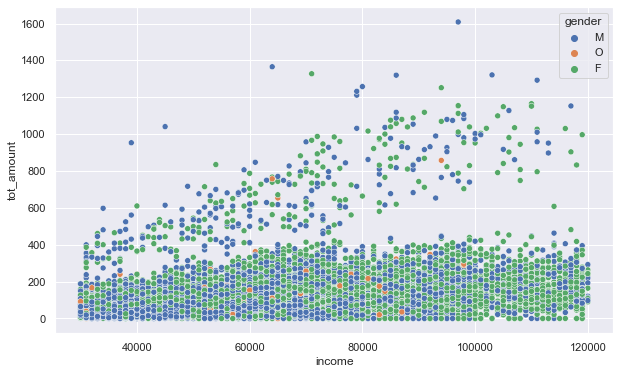

In [64]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ind_amt_v, x="income", y="tot_amount", hue="gender")
plt.show()

Some customers' total spending is increasing with their income level regardless of their gender. Majority of the customer's total spending doesn't change with their income. But some group of people spend higher amount than rest of them.

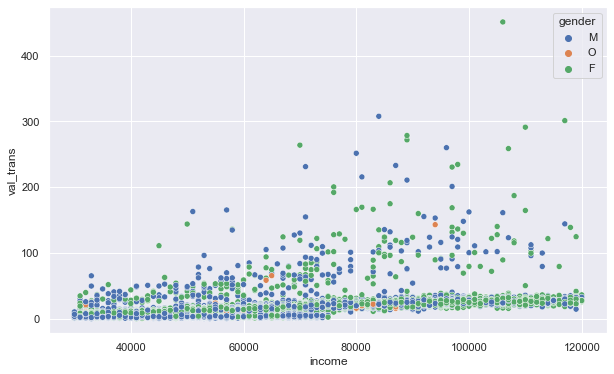

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ind_amt_v, x="income", y="val_trans", hue="gender")
plt.show()

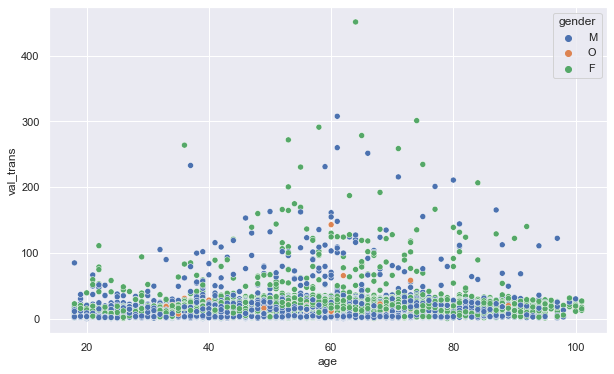

In [66]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ind_amt_v, x="age", y="val_trans", hue="gender")
plt.show()

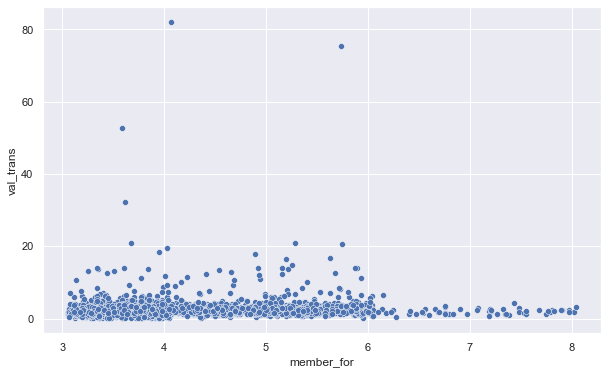

In [67]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_ind_amount[df_ind_amount.pf_age_valid == False], x="member_for", y="val_trans", hue="gender")
plt.show()

#### Rewards

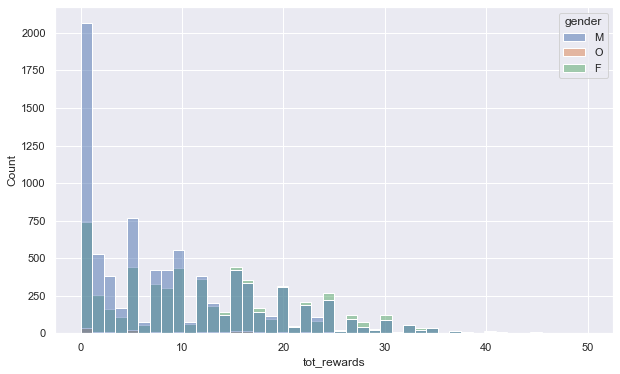

In [68]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ind_amount, x="tot_rewards", hue="gender")
plt.show()

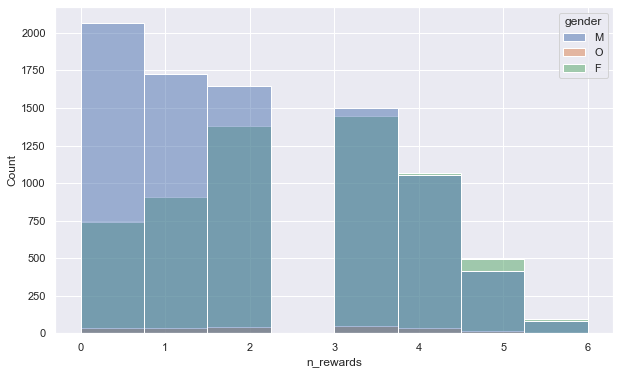

In [69]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ind_amount, x="n_rewards", bins=8, hue="gender")
plt.show()

### Total Transactions on an Offer

This part analyses the information related to the transaction while claiming the offer.

#### Offer ID Level

In [70]:
# get transaction on offers
df_offer_transac = get_OfferTransaction(df_transall, 'offer_id')

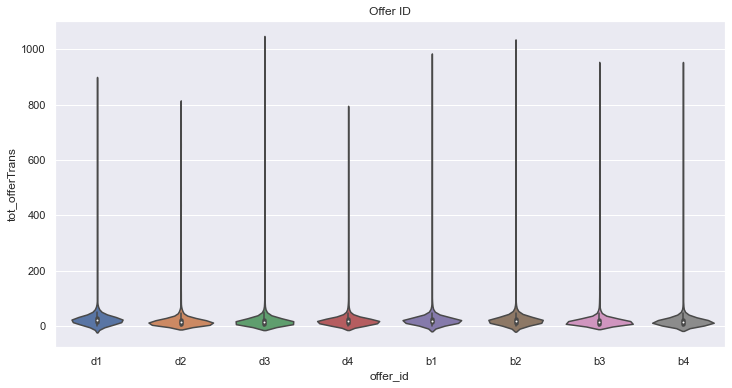

In [71]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="offer_id", y="tot_offerTrans",
                    order=["d1", "d2", "d3", "d4", "b1", "b2", "b3", "b4"],
                    data=df_offer_transac)
plt.title("Offer ID")
plt.show()

Transaction amount doesn't change much with the type of Offer (offer_id)

#### Offer Type Level

In [72]:
# get transaction on offers
df_offer_transac_ty = get_OfferTransaction(df_transall, 'offer_type')

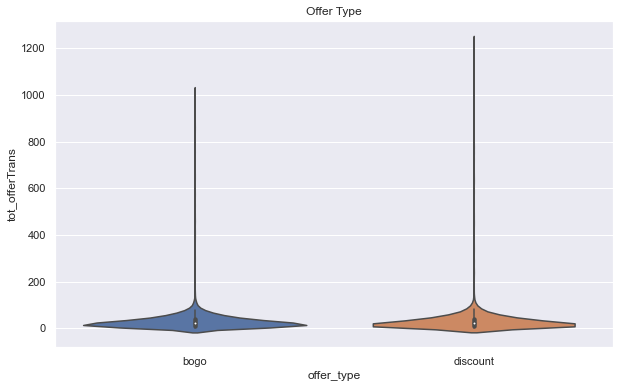

In [73]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x="offer_type", y="tot_offerTrans",
                    data=df_offer_transac_ty)
plt.title("Offer Type")
plt.show()

### Total Rewards and Offers

#### Offer Type Level

In [74]:
df_ind_offType_rewards = get_OfferReward(df_transall, 'offer_type')

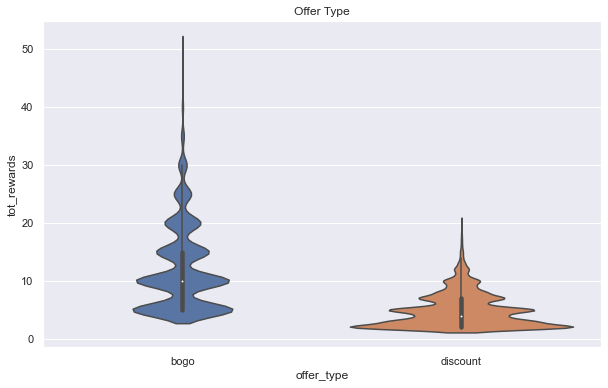

In [75]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x="offer_type", y="tot_rewards",
                    data=df_ind_offType_rewards)
plt.title("Offer Type")
plt.show()

Bogo gives more value to the customers than discount type of offers

#### Offer ID Level

In [76]:
df_ind_offid = get_OfferReward(df_transall, 'offer_id')

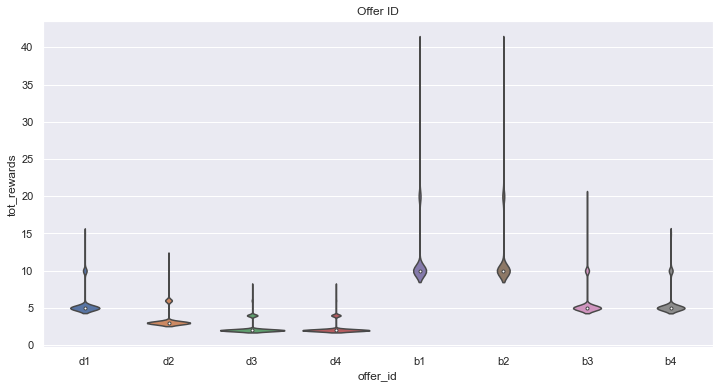

In [77]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="offer_id", y="tot_rewards",
                    order=["d1", "d2", "d3", "d4", "b1", "b2", "b3", "b4"],
                    data=df_ind_offid)
plt.title("Offer ID")
plt.show()

### Revenue vs Rewards

In [78]:
df_rev_rew_oty = pd.merge(df_ind_offType_rewards, df_offer_transac_ty,
                          on=['customer_id', 'offer_type'], how="left")

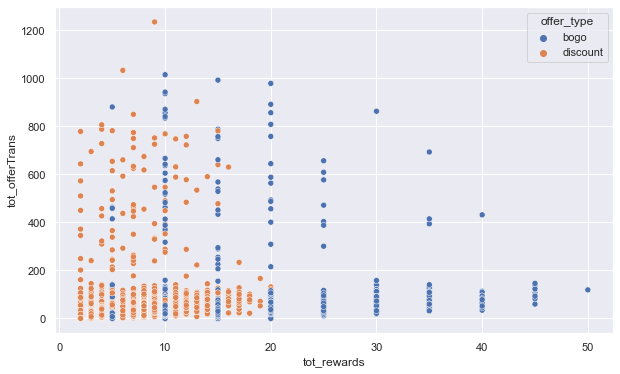

In [79]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_rev_rew_oty, x="tot_rewards", y="tot_offerTrans", hue="offer_type")
plt.show()

### Offer Counts and the Level of Engagements

Calculating customer level engagements to the offers sent out by the Starbucks. Ratios of Offer Received vs Offer Viewed, Offer Completed vs Offer Viewed for all types offers are calculated in this part.

In [80]:
df_ind_offEng = get_OfferEngagements(df_transall)
df_ind_offEng.head(3)

,customer_id,b_off_rec_view,b_off_rec_compl,d_off_rec_view,d_off_rec_compl,i_off_rec_view
0,0009655768c64bdeb2e877511632db8f,1.0,1.0,0.5,1.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,1.0,0.0,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,1.0,1.0,1.0


In [81]:
#converting the df wide to long form for visualisations
df_offEng_l = pd.melt(df_ind_offEng, id_vars=['customer_id'],
                      var_name = 'engagement',
                      value_vars=['b_off_rec_view', 'b_off_rec_compl', 'd_off_rec_view', 'd_off_rec_compl', 'i_off_rec_view'])

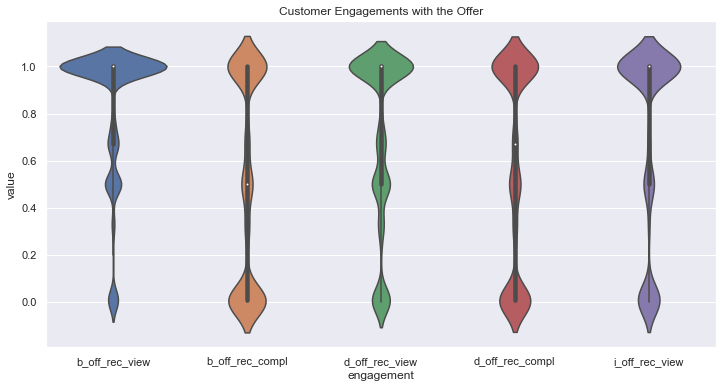

In [82]:
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='engagement', y="value", data=df_offEng_l)
plt.title("Customer Engagements with the Offer")
plt.show()

### Merge all Customer Level Information

In [83]:
# convert df_offer_transac_ty into a wide table
df_offer_trans_w = df_wide(df_offer_transac_ty,
                           index='customer_id', columns='offer_type', values='tot_offerTrans',
                           new_names = {'bogo':'trans_bogo', 'discount':'trans_discount'})

In [84]:
# convert df_ind_offType_rewards into a wide table
df_ind_offRe_w = df_wide(df_ind_offType_rewards,
                           index='customer_id', columns='offer_type', values='tot_rewards',
                           new_names = {'bogo':'rew_bogo', 'discount':'rew_discount'})

In [85]:
#merging all customer level tables
data_frames = [df_ind_amount, df_offer_trans_w, df_ind_offRe_w, df_ind_offEng]
df_sb_customers = reduce(lambda left, right: pd.merge(left, right,on=['customer_id'], how='outer'), data_frames)
df_sb_customers.head(3)

,customer_id,tot_amount,n_trans,tot_rewards,n_rewards,val_trans,val_rewards,gender,age,income,...,pf_age_valid,trans_bogo,trans_discount,rew_bogo,rew_discount,b_off_rec_view,b_off_rec_compl,d_off_rec_view,d_off_rec_compl,i_off_rec_view
0,0009655768c64bdeb2e877511632db8f,127.60,8,9.0,3,15.95,3.00,M,33.0,72000.0,...,True,8.57,24.38,5.0,4.0,1.0,1.0,0.5,1.0,1.0
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3,0.0,0,1.36,NaN,None,NaN,NaN,...,False,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5,13.0,3,15.89,4.33,O,40.0,57000.0,...,True,0.00,33.98,5.0,8.0,1.0,1.0,1.0,1.0,1.0


## Grouping Similar Customers Together

Intention of this part is grouping the customers who have similar behavior or engagement pattern using Clustering algorithms.

In [89]:
pf_gender = pd.get_dummies(df_sb_customers['gender'], prefix="gn")
df_sb = pd.concat([df_sb_customers, pf_gender], axis=1, sort=False)
df_sb.drop(columns=['gender', 'customer_id'], inplace=True)

scaler = StandardScaler()
df_sb = df_sb.fillna(0)
n_df_sb = scaler.fit_transform(df_sb)

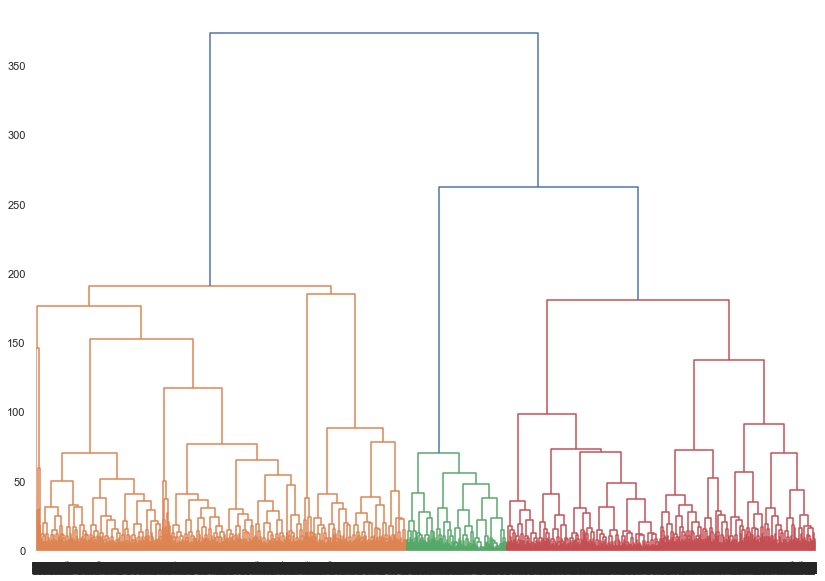

In [90]:
#drawing dendrogram
plt.figure(figsize=(14, 10))
dendrogram(ward(n_df_sb))
plt.show()

Above dentogram shows there are customer groups with distinct behavior and below summary tables reval what features are significant to each customer clusters.

In [91]:
cluster_Outcomes(n_df_sb, df_sb_customers, n_cluster=3)

,cluster,cl_count,m_trans,m_ntrans,m_rewards,m_nrewards,m_age,m_income,m_membY,m_bogo_compl,m_disc_compl,F,M,O,ratio_FM
0,0,8094,167.192326,8.638868,16.554608,3.031752,56.790462,71446.874228,4.508298,0.849837,0.789555,3962.0,3920.0,212.0,1.01
1,1,6731,56.705944,8.027633,3.660229,1.118853,51.511217,58139.652355,4.465105,0.123175,0.469933,2167.0,4564.0,NaN,0.47
2,2,2175,18.625090,6.894713,1.861609,0.511264,NaN,NaN,4.380998,0.108272,0.182733,NaN,NaN,NaN,NaN


Its an evidence gender, income, etc makes them naturally different and their choices are also slightly differnt.

## Building Recommender System

A recommender system will help Starbucks to identify best offer types for its customers based on similar customers' choices in the past. If a customer utilized an offer type that means thay like that offer more than the rest of the offers.
Offer utilization is defined as percentage of completion of an offer type out of number of offers they received.

Information are processed at Offer ID level to recommend offers at Offer ID level. Transaction data should be organised to support that above expeiment.

In [92]:
df_offEng_id = get_OfferEngagements_ID(df_transall)
df_offEng_id.head(3)

,customer_id,d1_compl_ratio,d2_compl_ratio,d3_compl_ratio,d4_compl_ratio,b1_compl_ratio,b2_compl_ratio,b3_compl_ratio,b4_compl_ratio
0,0009655768c64bdeb2e877511632db8f,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0
1,00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN


In [93]:
df_offEng_id.isna().sum()

customer_id           0
d1_compl_ratio    10620
d2_compl_ratio    10669
d3_compl_ratio    10662
d4_compl_ratio    10709
b1_compl_ratio    10620
b2_compl_ratio    10664
b3_compl_ratio    10639
b4_compl_ratio    10732
dtype: int64

This created a sparse matrix with higher level of NA values. NAs are converted to 0 to indicate they didn't receive show interest or didn't utilise that offer.

### Applying Collaborative Filtering

In [96]:
from surprise import Reader, Dataset
from surprise import SVD, SVDpp, CoClustering, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

Collaborative filtering is chosen to learn  customer behavior and  suggest best offers to customers. 

In [94]:
df_offEng_id['sum_na'] = df_offEng_id.isnull().sum(axis=1)
df_offEng_id['sum_na'].value_counts()

5    6520
6    4255
4    4099
7    1038
3     963
8      66
2      53
Name: sum_na, dtype: int64

In [95]:
df_eng_melted = pd.melt(df_offEng_id,
                        id_vars=["customer_id"],
                        value_vars=['d1_compl_ratio', 'd2_compl_ratio', 'd3_compl_ratio', 'd4_compl_ratio',
                                    'b1_compl_ratio', 'b2_compl_ratio', 'b3_compl_ratio', 'b4_compl_ratio'])
df_eng_melted.head(3)

,customer_id,variable,value
0,0009655768c64bdeb2e877511632db8f,d1_compl_ratio,NaN
1,00116118485d4dfda04fdbaba9a87b5c,d1_compl_ratio,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,d1_compl_ratio,1.0


In [97]:
#converting df format to surprise acceptable format
reader = Reader(rating_scale=(0, 1))
df_engf = df_eng_melted.fillna(0)

off_data = Dataset.load_from_df(df_engf, reader)

### Model - SVD

In [99]:
# SVD algorithm.
algo = SVD()
# Run 5-fold cross-validation for SVD
res1 = cross_validate(algo, off_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3933  0.3958  0.3943  0.3936  0.3924  0.3939  0.0011  
MAE (testset)     0.3016  0.3185  0.3059  0.3088  0.3119  0.3093  0.0057  
Fit time          7.67    7.73    7.94    7.82    7.87    7.81    0.09    
Test time         0.25    0.89    0.31    0.28    0.23    0.39    0.25    


### Model - SVD++

In [100]:
algo = SVDpp()

# Run 5-fold cross-validation for SVD++
res2 = cross_validate(algo, off_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3946  0.3966  0.3957  0.3989  0.3965  0.3964  0.0014  
MAE (testset)     0.3073  0.3084  0.3075  0.3113  0.3121  0.3093  0.0020  
Fit time          23.31   23.65   22.68   21.45   21.58   22.54   0.89    
Test time         0.61    0.58    0.56    0.62    0.63    0.60    0.03    


### Model - SlopeOne

In [101]:
algo = SlopeOne()

# Run 5-fold cross-validation for SlopeOne
res3 = cross_validate(algo, off_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4145  0.4163  0.4150  0.4155  0.4182  0.4159  0.0013  
MAE (testset)     0.3027  0.3051  0.3028  0.3037  0.3067  0.3042  0.0015  
Fit time          0.25    0.28    0.28    0.28    0.28    0.27    0.01    
Test time         0.37    0.37    0.38    0.29    0.30    0.34    0.04    


### Model - CoClustering

In [102]:
algo = CoClustering()

# Run 5-fold cross-validation for CoClustering
res4 = cross_validate(algo, off_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4374  0.4309  0.4332  0.4245  0.4348  0.4321  0.0044  
MAE (testset)     0.2987  0.2952  0.3029  0.2884  0.2962  0.2963  0.0048  
Fit time          5.83    5.45    5.47    5.69    5.27    5.54    0.19    
Test time         0.16    0.14    0.22    0.22    0.23    0.19    0.04    


The CoClustering  model shows better performance on the offer dataset, therefore CoClustering can be used to build the model and to fine tune.

### Finetune the Model

In [103]:
param_grid = {
    "n_epochs": [5, 10, 20],
    "n_cltr_u": [2, 3, 4],
    "n_cltr_i": [2, 3, 4]
}

# grid search
gs = GridSearchCV(CoClustering, param_grid, measures=["rmse", "mae"], cv=5)

gs.fit(off_data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.42465895086994665
{'n_epochs': 20, 'n_cltr_u': 2, 'n_cltr_i': 4}


### Fit the Final Model

Using entire dataset to build the final model

In [40]:
# Retrieve the trainset.
trainset = off_data.build_full_trainset()

algo = CoClustering(n_epochs=20, n_cltr_u=2, n_cltr_i=4)
algo.fit(trainset)

### Prediction

In [130]:
customer_id = str('0020ccbbb6d84e358d3414a3ff76cffd')
offer_id = str('d4_compl_ratio')  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific userID and offerID.
pred = algo.predict(customer_id, offer_id, verbose=True)

user: 0020ccbbb6d84e358d3414a3ff76cffd item: d4_compl_ratio r_ui = None   est = 0.62   {'was_impossible': False}


In [120]:
pred[3]

0.22038905410072832

Function to make recommendation

In [156]:
def get_recommendations(customer_id, model, n_rec=3):
  ''' function to recommend best offers to a customer '''
  
  est_score = []
  
  #offers
  l_offer = ['d1', 'd2', 'd3', 'd4', 'b1', 'b2', 'b3', 'b4']
  offers = ['{}_compl_ratio'.format(l) for l in l_offer]
  
  # get a prediction for specific userID and offerID.
  for offer in offers:
    pred = algo.predict(customer_id, offer, verbose=False)
    est_score.append(pred[3])
    
  df = pd.DataFrame({'offers':l1, 'score':l2})
  dft = df.sort_values(by=['score'], ascending=False).head(n_rec)
  
  return dft

In [158]:
get_recommendations(customer_id = str('0011e0d4e6b944f998e987f904e8c1e5'), model=algo, n_rec=5)

,offers,score
1,d2_compl_ratio,0.803849
6,b3_compl_ratio,0.764003
3,d4_compl_ratio,0.745004
2,d3_compl_ratio,0.397368
7,b4_compl_ratio,0.345389
